# VIT - Version 2.1.0 - Training a classifier

# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

!pip install einops
from einops import rearrange

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim

# from tqdm import tqdm
import time

device = 'cuda'

# Patch Embedding Class

process :

- input B C H W
- B C H W --> B (p1 p2) (h w c)
  - where h = H/patch_size , w = W/ patch_size
  - and p1, p2 = patch index
- output B N D

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.projection = nn.Linear(patch_size * patch_size * in_channels, embed_dim)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = rearrange(x, 'b c (p1 h) (p2 w) -> b (p1 p2) (h w c)', h=self.patch_size, w=self.patch_size)
        x = self.projection(x) # x = [B, N, D]
        return x, x.shape[1] # patches and num of patches

# Multi Head Attention

process :

- input B N D
- q = linear projection of input to D' = B N D'
- k = linear projection of input to D' = B N D'
- v = linear projection of input to D' = B N D'
- Rearrange into number of heads (D' is divisible by h, number of heads):
  - Q = B N D'=(h d) ---> B h n d where h is the number of head and d is the head dimension
  - K = B N D'=(h d) ---> B h n d where h is the number of head and d is the head dimension
  - V = B N D'=(h d) ---> B h n d where h is the number of head and d is the head dimension

- Q*K -> B h n n (multiplication on d and d of Q and K)
- scaled and softmaxed
- *V -> B h n d
-  Rearranged to B h n d --> B n (h d)


- in cvt Q*K -> B h n1 n2 where n1 could be equal to n2
  


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        # first dim is the dimension of embedded x second dim is the embedded dimension of q/k/v (could be different)
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)

        # fc_out as the final embedding of the attention. commonly used
        # self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):

        Q = rearrange(self.query(x), 'b n (h d) -> b h n d', h=self.num_heads)
        K = rearrange(self.key(x), 'b n (h d) -> b h n d', h=self.num_heads)
        V = rearrange(self.value(x), 'b n (h d) -> b h n d', h=self.num_heads)

        # Attention calculation
        attn = torch.einsum('bhid,bhjd->bhij', Q, K) * self.scale

        attention = F.softmax(attn, dim=-1)
        x = torch.einsum('bhij,bhjd->bhid', attention, V)
        x = rearrange(x, 'b h n d -> b n (h d)')
        # x = self.fc_out(x)
        return x

# Transformers Block (Encode Blocks)

process :

- define the attention block
- define the mlp block
  - two layers / GELU activation function
  - from embedded dimension (output of attention) to mlp dim  
  - and from mlp dim to embedded dimension (output of mlp usually the same as embed_dim)
- define layer norm

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_res = x
        x = self.norm1(x + self.dropout(self.attention(x)))
        x = self.norm2(x + self.dropout(self.mlp(x)))
        return x + x_res

# Vision Transformer

process :

- img_size is the size of the image
- patch size is the size of the patches
- in_channels is the number of input image channels
- num_classes is the number of classes
- embed_dim is the embedding dimension (for simplification we consider it to be equal in many layers)
- num_heads is the number of heads
- num_layers is the number of encode/transformer blocks
- mlp_dim is the hidden dimension of the mlp block
- dropout is the drop out rate


pos embedding :

- parameter added to the embedding patches
- input tensor is B (N) D , after cls token concatation
- pos embed shape is 1 N D
- simply add it to the input tensor / pytorch will broadcast it to all batches

cls_token :

- learnable parameters, a single learned embedding representing global information about the entire image.
- input tensor is B N D ,
- cls token parameter is 1 1 D
- expand cls token to (x.shape[0], -1, -1) : replicate for all batches
- cls token shape is B 1 D
- concat with input tensor on dim 1 (N - > N+1)
- result is B (N+1) D



classification :

- different methods
- google research simple vit uses cls token (learned) to classify images



In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self,
                 img_size=224,
                 patch_size=16,
                 in_channels=3,
                 num_classes=1000,
                 embed_dim=768,
                 num_heads=12,
                 num_layers=12,
                 mlp_dim=3072,
                 dropout=0.1
                 ):
        super(VisionTransformer, self).__init__()

        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)

        self.pos_embedding = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2, embed_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))

        self.transformer = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        # embed layer is the output of final mlp layer in the transformer block
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        patches, num_patches = self.patch_embedding(x)

        patches += self.pos_embedding

        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat([cls_tokens, patches], dim=1)

        for transformer_block in self.transformer:
            x = transformer_block(x)

        x = self.norm(x)
        cls_token_final = x[:, 0]
        output = self.fc(cls_token_final)
        return output


## Example

In [ ]:
vit = VisionTransformer(img_size=224, patch_size=16, in_channels=3, num_classes=10)

dummy_input = torch.randn(6, 3, 224, 224)
output = vit(dummy_input)
print(output.shape)

torch.Size([6, 10])


# Training a classifier

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## Load Dataset CIFAR10

100%|██████████| 170498071/170498071 [00:04<00:00, 41518444.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


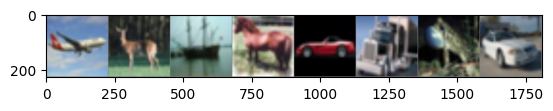

plane deer  ship  horse car   truck frog  car  
images size is : torch.Size([8, 3, 224, 224])


In [ ]:
transform = transforms.Compose([
      transforms.Resize(224),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
      ])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(f'images size is : {images.shape}')

## Optimizer and Criterion and model

In [ ]:
vit = VisionTransformer(img_size=224, patch_size=16, in_channels=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vit.parameters())


num_parameters = sum(p.numel() for p in vit.parameters() if p.requires_grad)

print(f'number of parameters : {num_parameters}')

number of parameters : 78718474


## Train/Test functions

In [ ]:
def train(epoch):
    # print('\nEpoch: %d' % epoch)
    vit.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = vit(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.shape[0]
        correct += predicted.eq(targets).sum().item()


    acc = 100.*correct/total
    # print(f'acc : {acc}')

    return train_loss/(batch_idx+1), acc # train loss mean over all batches (batches start from 0)

def test(epoch):
    vit.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = vit(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()


    acc = 100.*correct/total
    # print(f'acc : {acc}')

    return test_loss/(batch_idx+1), acc

# Train/Test the model

In [ ]:
def save_to_file(filename, result):
    with open(filename, 'w') as file:
        file.write(result)

In [ ]:
n_epochs = 200

train_list_loss = []
train_list_acc = []

test_list_loss = []
test_list_acc = []

best_acc_train = 0
best_acc_test= 0

# progress_bar = tqdm(total=n_epochs, desc='Training Progress', position=0)


for epoch in range(0, n_epochs):
    start = time.time()
    train_loss, train_acc = train(epoch)
    test_loss, test_acc = test(epoch)

    train_list_loss.append(train_loss)
    train_list_acc.append(train_acc)

    test_list_loss.append(test_loss)
    test_list_acc.append(test_acc)

    if test_acc > best_acc_test:
        best_acc_test = test_acc

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    tqdm_dict = {
        'Train Loss': train_loss,
        'Test Loss': test_loss,
        'Train Acc': train_acc,
        'Test Acc': test_acc,
        'Best Train Acc': best_acc_train,
        'Best Test Acc': best_acc_test,
        'Epoch Time': time.time() - start,
    }

    to_save = f"Epoch {epoch}/{n_epochs}\n{tqdm_dict}"
    filename = f'results/base_vit_v.2.0.1_epoch{epoch}.txt'
    save_to_file(filename,to_save)
    # print(f'saved to {filename}')
    # progress_bar.set_postfix(tqdm_dict)
    # progress_bar.set_description(f"Epoch {epoch}/{n_epochs}")


    # progress_bar.update(1)


# progress_bar.close()
